In [1]:
import pickle

In [2]:
with open('rnn_engine_no_query_256_d15_e20/valid_decode_e20.pkl', 'rb') as f:
    no_query = pickle.load(f)
with open('rnn_engine_catattn_256_d15_e20/valid_decode_e20.pkl', 'rb') as f:
    cat_attn = pickle.load(f)
# both epoch 20 is the best epoch
with open("data/shrdlurn/tokenized_s_val.pkl", "rb") as f:
    q_valid = pickle.load(f)

In [3]:
_PAD = b"<pad>"
_SOS = b"<sos>"
_EOS = b"<eos>"
_UNK = b"<unk>"
_START_VOCAB = [_PAD, _SOS, _EOS, _UNK]

PAD_ID = 0
SOS_ID = 1
EOS_ID = 2
UNK_ID = 3

def initialize_vocab(vocab_path):
    rev_vocab = []
    with open(vocab_path, mode="rb") as f:
        rev_vocab.extend(f.readlines())
    rev_vocab = [line.strip('\n') for line in rev_vocab]
    vocab = dict([(x, y) for (y, x) in enumerate(rev_vocab)])
    return vocab, rev_vocab

def detokenize(sents, reverse_vocab, decode=False):
    space = ""
    if decode:
        space = " "

    def detok_sent(sent):
        outsent = ''
        for t in sent:
            if t >= len(_START_VOCAB):
                outsent += reverse_vocab[t] + space  # this might not be right...
        return outsent

    return [detok_sent(s) for s in sents]

def detokenize_to_list(sents, reverse_vocab):
    def detok_sent(sent):
        outsent = []
        for t in sent:
            if t >= len(_START_VOCAB):
                outsent.append(reverse_vocab[t])  # this might not be right...
        return outsent

    return [detok_sent(s) for s in sents]

In [4]:
src_vocab, rev_src_vocab = initialize_vocab("data/shrdlurn/src_vocab.dat")
tgt_vocab, rev_tgt_vocab = initialize_vocab("data/shrdlurn/tgt_vocab.dat")
env_vocab, rev_env_vocab = initialize_vocab("data/shrdlurn/env_vocab.dat")

In [26]:
cat_attn[0]

{'cmd': ['keep', 'brown', 'right'],
 'ctx': ['[',
  '1',
  ']',
  '[',
  '0',
  ']',
  '[',
  '0',
  ']',
  '[',
  '0',
  ']',
  '[',
  '1',
  ']'],
 'decoded': '[ 1 ] ',
 'truth': ['[', '1', ']', '']}

In [29]:
src_decoded = detokenize_to_list([q_valid[0][0]], rev_src_vocab)[0]
print src_decoded
print cat_attn[0]['cmd']
print src_decoded == cat_attn[0]['cmd']
# also they are in the same order

['keep', 'brown', 'right']
['keep', 'brown', 'right']
True


In [31]:
print detokenize_to_list([q_valid[0][1]], rev_tgt_vocab)
print detokenize_to_list([q_valid[0][2]], rev_env_vocab)

[['(targetFormula', '(call', 'wallToString', '(call', 'context:removeTop', '(call', 'complement', '(call', 'rightMost1', '(call', 'context:getTopColor', '(number', '1', 'COLOR)', ')', ')', ')', ')', ')', ')']]
[['[', '1', ']', '[', '0', ']', '[', '0', ']', '[', '0', ']', '[', '1', ']']]


In [8]:
def check_correct(result1):
    pred_env = result1['decoded'].strip()
    true_env = " ".join(result1['truth']).strip()
    return pred_env == true_env

print cat_attn[1]['decoded']
print " ".join(cat_attn[1]['truth'])
print check_correct(cat_attn[1])

[ 1 ] [ 1 ] [ 3 ] [ 1 ] 
[ 1 ] [ 1 ] [ 3 ] [ 1 ] 
True


In [32]:
# 1. Could track the progression of learning through epochs (if we can categorize entries, 
# then we can track the rate of accuracy growing)
# 2. Categories don't have to be mutually exclusive

# Categories:
# 1. Logical difficulty (based on the length of parsed logical form, could do depth as well)
# 2. Language transferrability (what's the dominant language in the corpus? Is it English?) 
#   (Divide by: "English/abbreviated English", "Pure number")

1245

## What is learned by adding Query? (compare to no_query)

In [18]:
# Predictions learned by Cat_attn but not no_query
pred_learned_by_add_query = []
pred_confused_by_add_query = []

for i in range(len(cat_attn)):
    # we track things learned by cat_attn but not no_query
    # and things that got right by no_query, but got wrong by cat_attn
    if check_correct(cat_attn[i]) and not check_correct(no_query[i]):
        pred_learned_by_add_query.append(cat_attn[i])  # , no_query[i]]  # save both
    if not check_correct(cat_attn[i]) and check_correct(no_query[i]):
        pred_confused_by_add_query.append(cat_attn[i])  # , no_query[i]]

In [19]:
print len(pred_learned_by_add_query)
print len(pred_confused_by_add_query)

580
61


In [ ]:
# 1. Plot the difference in stats about what's learned by adding query
# 2. Plot the difference in stats about what's learned by directly predicting output, compare to parsing logical form 
# (essentially what specifically did predicting output is able to solve but parsing can't - maybe we'll gain new insights
# maybe not...)
# 3. summarize your story into README

In [21]:
# 1. How many more English/non-Enligsh command can be solved by direct prediction?
english, non_english = accuracy_by_language_type(pred_learned_by_add_query)
print "num of English: ", len(english)
print "num of non-English: ", len(non_english)
# so out of 580 newly learned ones, 475 are "English"
# num of English:  962
# num of non-English:  283
print 475. / 105.
print 962. / 283.

# this means conditioning on the query helps us solve English (common) language more than 
# help us solve non-English language

num of English:  475
num of non-English:  105
4.52380952381
3.39929328622


In [30]:
def accu_perc(accu_num_dict, dist_dict):
    accu_dict = {}

    for k, v in accu_num_dict.iteritems():
        accu_dict[k] = float(accu_num_dict[k]) / dist_dict[k]
    return accu_dict

In [34]:
print accuracy_by_logic_length(cat_attn)[1]

{10: 8, 13: 130, 14: 392, 16: 129, 17: 306, 19: 51, 20: 229}


In [29]:
# 2. Is the model better at learning learning harder/longer logical forms?
print accuracy_by_logic_length(cat_attn)[0]  # we only need one because they are all correct
print accuracy_by_logic_length(no_query)[0]

{10: 2, 13: 67, 14: 293, 16: 84, 17: 188, 19: 13, 20: 133}
{10: 0, 13: 26, 14: 146, 16: 5, 17: 63, 19: 0, 20: 21}


In [32]:
cat_attn_accu_perc = accu_perc(accuracy_by_logic_length(cat_attn)[0], accuracy_by_logic_length(cat_attn)[1])
no_query_accu_perc = accu_perc(accuracy_by_logic_length(no_query)[0], accuracy_by_logic_length(no_query)[1])
print cat_attn_accu_perc
print no_query_accu_perc

{10: 0.25, 13: 0.5153846153846153, 14: 0.7474489795918368, 16: 0.6511627906976745, 17: 0.6143790849673203, 19: 0.2549019607843137, 20: 0.5807860262008734}
{10: 0.0, 13: 0.2, 14: 0.37244897959183676, 16: 0.03875968992248062, 17: 0.20588235294117646, 19: 0.0, 20: 0.09170305676855896}


In [33]:
# print out the percentage increase
for k, v in cat_attn_accu_perc.iteritems():
    print k, ": ", v - no_query_accu_perc[k]

# from this we kinda sorta know the medium length logical form gets improved the most!? 
# 16 does not have the most amount of training data

10 :  0.25
13 :  0.315384615385
14 :  0.375
16 :  0.612403100775
17 :  0.408496732026
19 :  0.254901960784
20 :  0.489082969432


In [54]:
# 3. Is the model better at interpreting certain actions?
cat_attn_action_type_accu_num_dict = {'remove':0, 'add':0, 'put':0, 'stack':0}
action_type_dist = {'remove':0, 'add':0, 'put':0, 'stack':0}

accuracy_by_action_type(cat_attn, cat_attn_action_type_accu_num_dict, action_type_dist)

no_query_action_type_accu_num_dict = {'remove':0, 'add':0, 'put':0, 'stack':0}
action_type_dist = {'remove':0, 'add':0, 'put':0, 'stack':0}

accuracy_by_action_type(no_query, no_query_action_type_accu_num_dict, action_type_dist)


print action_type_dist
print cat_attn_action_type_accu_num_dict
print no_query_action_type_accu_num_dict


{'put': 94, 'add': 275, 'stack': 31, 'remove': 564}
{'put': 67, 'add': 169, 'stack': 17, 'remove': 389}
{'put': 1, 'add': 17, 'stack': 1, 'remove': 177}


## What is learned by adding Query? (compare to RNN_Logic)

In [42]:
# Predictions learned by Cat_attn but not no_query
pred_learned_by_pred_env = []
pred_confused_by_pred_env = []

for i in range(len(cat_attn)):
    # we track things learned by cat_attn but not no_query
    # and things that got right by no_query, but got wrong by cat_attn
    if check_correct(cat_attn[i]) and not check_correct(seq_nlc[i]):
        pred_learned_by_pred_env.append(cat_attn[i])  # , no_query[i]]  # save both
    if not check_correct(cat_attn[i]) and check_correct(seq_nlc[i]):
        pred_confused_by_pred_env.append(cat_attn[i])  # , no_query[i]]

In [43]:
print len(pred_learned_by_pred_env)
print len(pred_confused_by_pred_env)

270
173


In [ ]:
# interesting, so you really win some and lose some. This is a bit unexpected
# even though both approaches have similar overall accuracy 55.90 vs. 64.17

# So for the winning side


### Conclusion
This means that by adding query, we are able to learn 580 examples that previously are not learnable, and it accounts for 46.58% of the vadliation corpus (1245 examples). However, by adding query, model gets 61 examples wrong. This could be a problem of insufficient parameter learning (1.84M vs. 2.63M)

## Length of Logical Form

In [54]:
def check_accuracy(results):
    num_correct = 0.
    for res in results:
        if check_correct(res):
            num_correct += 1
    return num_correct / len(results)

In [55]:
check_accuracy(cat_attn)

0.6265060240963856

In [59]:
q_valid[0]

[[111, 7, 23],
 [8, 5, 9, 5, 11, 5, 18, 5, 20, 5, 10, 7, 13, 6, 4, 4, 4, 4, 4, 4],
 [4, 7, 5, 4, 6, 5, 4, 6, 5, 4, 6, 5, 4, 7, 5],
 [4, 7, 5]]

In [22]:
def accuracy_by_logic_length(results):
    logic_len_accu_dict = {}
    logic_len_dist = {}
    for i in range(len(results)):
        logic_len = len(q_valid[i][1])
        if logic_len not in logic_len_dist:
                logic_len_dist[logic_len] = 1
        else:
            logic_len_dist[logic_len] += 1
                
        if check_correct(results[i]):
            if logic_len not in logic_len_accu_dict:
                logic_len_accu_dict[logic_len] = 1
            else:
                logic_len_accu_dict[logic_len] += 1
        else:
            if logic_len not in logic_len_accu_dict:
                logic_len_accu_dict[logic_len] = 0
    return logic_len_accu_dict, logic_len_dist

In [69]:
logic_len_accu_num_dict, logic_len_dist = accuracy_by_logic_length(cat_attn)
print logic_len_dist
print logic_len_accu_num_dict

{10: 8, 13: 130, 14: 392, 16: 129, 17: 306, 19: 51, 20: 229}
{10: 2, 13: 67, 14: 293, 16: 84, 17: 188, 19: 13, 20: 133}


In [70]:
# compute the percentage of accuracy by logic length
# might need to check logic depth as a better measurement
logic_len_accu_dict = {}
for k, v in logic_len_dist.iteritems():
    logic_len_accu_dict[k] = float(logic_len_accu_num_dict[k]) / logic_len_dist[k]

In [73]:
for k, v in logic_len_dist.iteritems():
    print str(k) + ": " + str(v)

10: 8
13: 130
14: 392
16: 129
17: 306
19: 51
20: 229


In [71]:
logic_len_accu_dict

{10: 0.25,
 13: 0.5153846153846153,
 14: 0.7474489795918368,
 16: 0.6511627906976745,
 17: 0.6143790849673203,
 19: 0.2549019607843137,
 20: 0.5807860262008734}

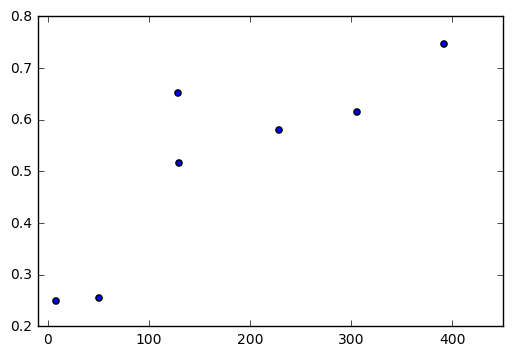

In [78]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

x = []; y = []
for k, v in logic_len_accu_dict.iteritems():
    x.append(logic_len_dist[k]); y.append(v)

plt.xlim(-10, 450)
plt.scatter(x, y)

In [35]:
# we compare this to RNN_Logic's result, because that result should have been affected by length of query!
with open('rnn_nlc_attn_256_d15_e20/valid_decode_e9.pkl', 'rb') as f:
    seq_nlc = pickle.load(f)

In [184]:
logic_len_accu_num_dict, logic_len_dist = accuracy_by_logic_length(seq_nlc)
print logic_len_dist
print logic_len_accu_num_dict

{10: 8, 13: 130, 14: 392, 16: 129, 17: 306, 19: 51, 20: 229}
{10: 0, 13: 42, 14: 340, 16: 89, 17: 145, 19: 31, 20: 36}


In [185]:
logic_len_accu_dict = {}
for k, v in logic_len_dist.iteritems():
    logic_len_accu_dict[k] = float(logic_len_accu_num_dict[k]) / logic_len_dist[k]

for k, v in logic_len_dist.iteritems():
    print str(k) + ": " + str(v)

print ""

logic_len_accu_dict

10: 8
13: 130
14: 392
16: 129
17: 306
19: 51
20: 229



{10: 0.0,
 13: 0.3230769230769231,
 14: 0.8673469387755102,
 16: 0.689922480620155,
 17: 0.4738562091503268,
 19: 0.6078431372549019,
 20: 0.1572052401746725}

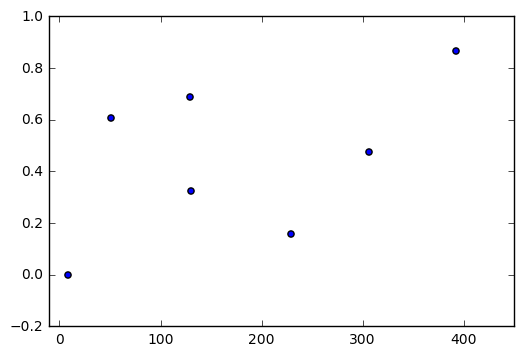

In [186]:
# This shows the influence of training size on accuracy
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

x = []; y = []
for k, v in logic_len_accu_dict.iteritems():
    x.append(logic_len_dist[k]); y.append(v)

plt.xlim(-10, 450)
plt.scatter(x, y)

# This shows that training size is not linearly correlated with accuracy

10: 8
13: 130
14: 392
16: 129
17: 306
19: 51
20: 229


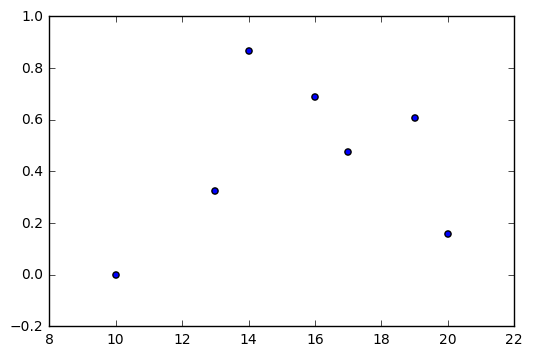

In [188]:
# We now show the length influence on accuracy
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

x = []; y = []
for k, v in logic_len_accu_dict.iteritems():
    x.append(k); y.append(v)

# plt.xlim(-10, 450)
plt.scatter(x, y)

for k, v in logic_len_dist.iteritems():
    print str(k) + ": " + str(v)

This plot shows that length does matter if we plot for the RNN_Logic (which is expected)

### Conclusion
Even though we are not directly training on nor predicting logical form, it seems like the sheer length of logic form does not entirely correlate with learnability. However, from the scatter plot, we can also see it's not entirely a linear relationship with training size either. (Length 13 and 16 have different accuracy but similar size)

This result is slightly different from CLEVR where it has been (probably) demonstrated that longer/deeper logical form is harder to directly predict the next step.

## Logic Tree Depth

In [ ]:
# following from the inconclusion of length, we now look towards depth of tree

In [79]:
import nltk
from nltk.tree import Tree

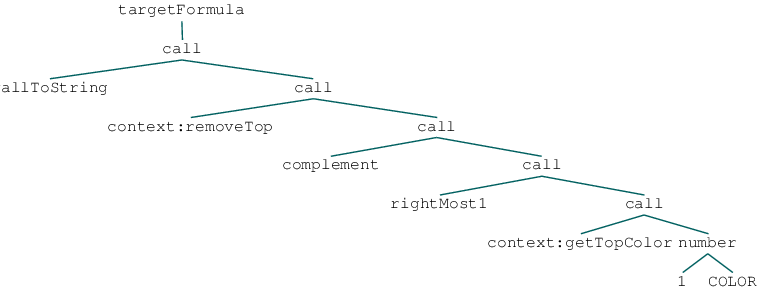

In [101]:
tree = Tree.fromstring(detokenize([q_valid[0][1]], rev_tgt_vocab, decode=True)[0].strip())
Tree.fromstring(detokenize([q_valid[0][1]], rev_tgt_vocab, decode=True)[0].strip())

In [95]:
# tested, should be correct
def get_depth(tree):
    curr_depth = []
    def get_depth_recur(tree, depth):
        curr_depth.append(depth)
        for subtree in tree:
            if type(subtree) == nltk.tree.Tree:
                get_depth_recur(subtree, depth+1)
    get_depth_recur(tree, 0)
    return max(curr_depth)

In [102]:
def get_logic_depth(result):
    tree = Tree.fromstring(detokenize([result], rev_tgt_vocab, decode=True)[0].strip())
    return get_depth(tree)

def accuracy_by_logic_depth(results):
    logic_depth_accu_dict = {}
    logic_depth_dist = {}
    for i in range(len(results)):
        logic_depth = get_logic_depth(q_valid[i][1])
        if logic_depth not in logic_depth_dist:
                logic_depth_dist[logic_depth] = 1
        else:
            logic_depth_dist[logic_depth] += 1
                
        if check_correct(results[i]):
            if logic_depth not in logic_depth_accu_dict:
                logic_depth_accu_dict[logic_depth] = 1
            else:
                logic_depth_accu_dict[logic_depth] += 1
    return logic_depth_accu_dict, logic_depth_dist

In [103]:
logic_depth_accu_num_dict, logic_depth_dist = accuracy_by_logic_depth(cat_attn)
print logic_depth_dist
print logic_depth_accu_num_dict

{3: 20, 4: 756, 5: 448, 6: 21}
{3: 8, 4: 516, 5: 242, 6: 14}


In [106]:
logic_depth_accu_dict = {}
for k, v in logic_depth_dist.iteritems():
    logic_depth_accu_dict[k] = float(logic_depth_accu_num_dict[k]) / logic_depth_dist[k]

for k, v in logic_depth_accu_dict.iteritems():
    print str(k) + ": " + str(v)

3: 0.4
4: 0.68253968254
5: 0.540178571429
6: 0.666666666667


In [114]:
def filter_by_depth(results, preds):
    logic_depth_dist = {}
    for i in range(len(results)):
        logic_depth = get_logic_depth(q_valid[i][1])
        if logic_depth not in logic_depth_dist:
                logic_depth_dist[logic_depth] = [[check_correct(preds[i]), detokenize([q_valid[i][1]], rev_tgt_vocab, decode=True)[0].strip()]]
        else:
            logic_depth_dist[logic_depth].append([check_correct(preds[i]), detokenize([q_valid[i][1]], rev_tgt_vocab, decode=True)[0].strip()])
    return logic_depth_dist

def filter_by_depth_ctx(results, preds):
    logic_depth_dist = {}
    for i in range(len(results)):
        logic_depth = get_logic_depth(q_valid[i][1])
        if logic_depth not in logic_depth_dist:
                logic_depth_dist[logic_depth] = [[check_correct(preds[i]), detokenize([q_valid[i][2]], rev_env_vocab, decode=True)[0].strip()]]
        else:
            logic_depth_dist[logic_depth].append([check_correct(preds[i]), detokenize([q_valid[i][2]], rev_env_vocab, decode=True)[0].strip()])
    return logic_depth_dist

dict_by_length = filter_by_depth(q_valid, cat_attn)
# dict_by_length[3]
dict_by_length_ctx = filter_by_depth_ctx(q_valid, cat_attn)
dict_by_length_ctx[3]

[[True, '[ 0 ] [ 2 ] [ 0 ] [ 2 ] [ 0 ]'],
 [True, '[ 0 ] [ 1 0 ] [ 0 ] [ 1 0 ]'],
 [False, '[ 3 ] [ 0 ] [ 2 ] [ 0 ] [ 0 ]'],
 [False, '[ 2 2 ] [ 2 3 ] [ 2 2 ]'],
 [False, '[ 1 ] [ 3 ] [ 0 ] [ 3 ] [ 2 ] [ 3 ]'],
 [False, '[ 2 ] [ 0 ] [ 0 ] [ 2 ] [ 0 ] [ 0 ] [ 1 ]'],
 [False, '[ 3 ] [ 3 ] [ 3 ] [ 1 ] [ 0 ] [ 3 ]'],
 [True, '[ 1 ] [ 0 ] [ 0 ] [ 1 ] [ 0 ]'],
 [False, '[ 1 ] [ 2 ] [ 3 ] [ 0 ] [ 0 ]'],
 [False, '[ 3 3 ] [ 2 ] [ 2 ] [ 3 ]'],
 [True, '[ 1 1 ] [ 1 0 0 ] [ 1 0 0 0 ] [ 1 0 0 ] [ 1 1 ]'],
 [True, '[ 2 ] [ 2 ] [ 2 ] [ 3 ]'],
 [False, '[ 1 ] [ 0 ] [ 3 ] [ 2 ] [ 0 ] [ 0 ] [ 2 ]'],
 [False, '[ 3 3 ] [ 3 2 ] [ 3 3 ]'],
 [True, '[ 0 0 ] [ 0 ] [ 0 0 ] [ 0 ] [ 0 0 ] [ 0 ]'],
 [True, '[ 2 ] [ 3 ] [ 2 ] [ 3 ] [ 2 ] [ 3 ]'],
 [False, '[ 0 ] [ 2 ] [ 0 ] [ 3 ] [ 3 ] [ 1 ]'],
 [False, '[ 1 ] [ 1 ] [ 0 ] [ 1 ] [ 0 ] [ 1 ]'],
 [False, '[ 2 2 ] [ 2 3 3 ] [ 2 3 3 3 ] [ 2 3 3 ] [ 2 2 ]'],
 [True, '[ 3 ] [ 3 ] [ 3 ] [ 3 ]']]

### Conclusion

Since the variation of logical form depth is so narrow, we are not able to conclude much, and this reveals less information and length. However, a parculiar trend is that shallowest form is hardest to learn? This is counterintuitive. We examined the shallow logical forms (their actions) and the context they need to transform, but **no immediate common characteristics** are shared among correct and wrong ones.

## Language Categorization

In [176]:
# we use verb/action categorization to determine English/non-English
# it's a shortcut but should work

In [15]:
def accuracy_by_language_type(preds):
    # could do automatic first word collapsing (for further analysis)
    non_english = []
    english = []
    for i in range(len(preds)):
        lower_cmd = lower_case_list(preds[i]['cmd'])
        if "remove" in lower_cmd or "rm" in lower_cmd or "delete" in lower_cmd or "del" in lower_cmd or "clear" in lower_cmd or "clr" in lower_cmd:
            english.append(preds[i])
        elif "put" in lower_cmd or "place" in lower_cmd:
            english.append(preds[i])
        elif "add" in lower_cmd:
            english.append(preds[i])
        elif "stack" in lower_cmd:
            english.append(preds[i])
        else:
            non_english.append(preds[i])

    return english, non_english

In [169]:
english, non_english = accuracy_by_language_type(cat_attn)
print "num of English: ", len(english)
print "num of non-English: ", len(non_english)

num of English:  962
num of non-English:  283


In [175]:
print "accuracy of English: ", check_accuracy(english)
print "accuracy of non-English: ", check_accuracy(non_english)

accuracy of English:  0.665280665281
accuracy of non-English:  0.494699646643


### Conclusion

We note that for many non-english command, they don't share enough characteristics, but the model is still able to learn well.

## Verb/Action Categorization

In [47]:
def lower_case_list(l):
    return [s.lower() for s in l]

def accuracy_by_action_type(preds, action_type_accu_dict, action_type_dist):
    # could do automatic first word collapsing (for further analysis)
    for i in range(len(preds)):
        lower_cmd = lower_case_list(preds[i]['cmd'])
        triggered = 0
        if "remove" in lower_cmd or "rm" in lower_cmd or "delete" in lower_cmd or "del" in lower_cmd or "clear" in lower_cmd or "clr" in lower_cmd:
            action_type_dist['remove'] += 1
            triggered += 1
            if check_correct(preds[i]):
                action_type_accu_dict['remove'] += 1
        if "put" in lower_cmd or "place" in lower_cmd:
            action_type_dist['put'] += 1
            triggered += 1
            if check_correct(preds[i]):
                action_type_accu_dict['put'] += 1
        if "add" in lower_cmd:
            action_type_dist['add'] += 1
            triggered += 1
            if check_correct(preds[i]):
                action_type_accu_dict['add'] += 1
        if "stack" in lower_cmd:
            action_type_dist['stack'] += 1
            triggered += 1
            if check_correct(preds[i]):
                action_type_accu_dict['stack'] += 1
#         if triggered > 1:
#             print preds[i]['cmd']

In [166]:
action_type_accu_num_dict = {'remove':0, 'add':0, 'put':0, 'stack':0}
action_type_dist = {'remove':0, 'add':0, 'put':0, 'stack':0}

accuracy_by_action_type(cat_attn, action_type_accu_num_dict, action_type_dist)

print action_type_dist
print action_type_accu_dict
total = 0
for k, v in action_type_dist.iteritems():
    total += v
print "total number of covered examples: ", total, "out of", len(cat_attn)

# only 2 examples in validation where in command, more than one action is mentioned 

{'put': 94, 'add': 275, 'stack': 31, 'remove': 564}
{'put': 0.7093023255813954, 'add': 0.6145454545454545, 'stack': 0.5483870967741935, 'remove': 0.6897163120567376}
total number of covered examples:  964 out of 1245


In [167]:
action_type_accu_dict = {}

for k, v in action_type_dist.iteritems():
    action_type_accu_dict[k] = float(action_type_accu_num_dict[k]) / action_type_dist[k]

for k, v in action_type_dist.iteritems():
    print str(k) + ": " + str(v)

print ""
    
for k, v in action_type_accu_dict.iteritems():
    print str(k) + ": " + str(v)

put: 94
add: 275
stack: 31
remove: 564

put: 0.712765957447
add: 0.614545454545
stack: 0.548387096774
remove: 0.689716312057


### Conclusion

This is rather interesting. The result is irrelevant to verb/action types' training size. 

## Additional Explorations
- Plot the learned embeddings of actions (assume action is the first word), determine action by logic form
- Plot attention map of cat_attn to figure out which words are most responsible for correct action/prediction on the enviornment (especially interesting for non-English code)